In [3]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import grad
from torch.autograd.functional import hessian
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
from tqdm import tqdm
from torch.optim import Adam, SGD, LBFGS
torch.set_printoptions(precision=2)

In [4]:
def same_seed(seed):
    # set seeds
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

In [5]:
def extend_matrix(B: torch.tensor):
    num_users, num_movies = B.size()
    # Extend B matrix
    B_ext = torch.zeros((num_users + num_movies, num_users + num_movies))
    B_ext[num_users:, :num_users] = B.T
    B_ext[:num_users, num_users:] = B
    # Create mask
    mask = torch.zeros((num_users + num_movies, num_users + num_movies))
    mask[num_users:, :num_users] = 1
    mask[:num_users, num_users:] = 1

    return B_ext, mask

In [6]:
def compute_Z(B: torch.Tensor, dim=2, iter=1000, lr=0.001):
    B, mask = extend_matrix(B)
    def loss_func(x):
        return ((x @ x.T - B) * mask).square().sum()
    # Initialize
    Z = torch.rand((B.size(0), dim), requires_grad=True)
    loss = []
    for i in range(iter):
        f = ((Z @ Z.T - B) * mask).square().sum()
        # print(hessian(loss_func, Z))
        loss.append(f.item())
        f.backward()
        Z.data = Z.data - lr * Z.grad.data
        Z.grad.data.zero_()
    return Z, B, mask, loss

In [7]:
def loss_fn(Z, f, type='A', coeff=0.1):
    def loss_A(X, E):
        w, h = X.size()
        dist_loss = -torch.linalg.matrix_norm(X - Z)
        first_order_loss = torch.linalg.matrix_norm(grad(f(X, E), X, create_graph=True)[0])
        second_order_loss = -torch.linalg.eigvalsh(hessian(f, (X, E), create_graph=True)[0][0].reshape(w,h,-1).reshape(w*h,-1))[0]
        return dist_loss + first_order_loss + second_order_loss, dist_loss.item(), first_order_loss.item(), second_order_loss.item()
    def loss_B(X, E):
        w, h = X.size()
        dist_loss = -torch.linalg.matrix_norm(X - Z)
        first_order_loss = torch.linalg.matrix_norm(grad(f(X, E), X, create_graph=True)[0])
        second_order_loss = -torch.linalg.eigvalsh(hessian(f, (X, E), create_graph=True)[0][0].reshape(w,h,-1).reshape(w*h,-1))[0]
        return dist_loss + coeff * torch.max(first_order_loss, second_order_loss), dist_loss.item(), first_order_loss.item(), second_order_loss.item()
    return loss_A if type == 'A' else loss_B

In [8]:
def compute_X_E(B: torch.Tensor, dim=2, iter=3000, lr=0.001, max_norm=1e-1, loss_type='A', coeff=0.1):
    same_seed(0)
    # Compute the global optimal solution
    Z, B, mask, _ = compute_Z(B, dim, iter, lr)
    def f(x, e):
        return ((x @ x.T - Z @ Z.T + e) * mask).square().sum()
    criterion = loss_fn(Z, f, loss_type, coeff)
    X = torch.rand((B.size(0), dim), requires_grad=True)
    E = torch.zeros(B.size(), requires_grad=True)
    losses = []
    for i in range(iter):
        loss, dist, grad, hess = criterion(X, E)
        losses.append((loss.item(), dist, grad, hess))
        loss.backward()
        # GD
        X.data = X.data - lr * X.grad.data
        E.data = E.data - lr * E.grad.data
        # Clear the gradients
        X.grad.data.zero_()
        E.grad.data.zero_()
        # Restrict the norm of error
        norm_E = torch.linalg.matrix_norm(E * mask)
        if norm_E > np.sqrt(2) * max_norm:
            E.data = E.data / norm_E * np.sqrt(2) * max_norm
        # Adjust learning rate
        if (i + 1) % (iter // 3) == 0:
            lr = lr * 0.1
    return X, E, Z, losses
    

In [9]:
B = torch.tensor([
    [1, 0, 1, 1, 0],
    [0, 1, 0, 0, 1],
    [1, 1, 1, 0, 0],
    [0, 0, 0, 1, 1]
])
# Z, _, _, losses = compute_Z(B)
# U = Z[:B.size(0)]
# V = Z[B.size(0):]
# Z_hat = U @ V.T
# print(Z_hat)
embed_dim = 1
E_max_norm = 1e-1
loss_type = 'B'
coeff = 1

X, E, Z, losses = compute_X_E(
    B, 
    embed_dim, 
    max_norm=E_max_norm,
    loss_type=loss_type,
    coeff=coeff
)
# print(X)
# print(Z)
print(B)
print(X[:B.size(0)] @ X[B.size(0):].T)
print(Z[:B.size(0)] @ Z[B.size(0):].T)
print(E)

KeyboardInterrupt: 

In [10]:
def plot_loss(losses):
    fig, ax = plt.subplots(2, 2, figsize=(20, 20), tight_layout=True)
    loss = [loss[0] for loss in losses]
    dist = [loss[1] for loss in losses]
    grad = [loss[2] for loss in losses]
    hess = [loss[3] for loss in losses]
    
    ax[0][0].plot(loss)
    ax[0][1].plot(dist)
    ax[1][0].plot(grad)
    ax[1][1].plot(hess)

    ax[0][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][0].set_ylabel(r"$G(X,\epsilon)$", fontsize=30)
    ax[0][0].set_title(f"Total Loss vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][0].xaxis.set_tick_params(labelsize=20)
    ax[0][0].yaxis.set_tick_params(labelsize=20)
    ax[0][0].grid()

    ax[0][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][1].set_ylabel(r"$-\|X-Z\|$", fontsize=30)
    ax[0][1].set_title(r"$-\|X-Z\|$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][1].xaxis.set_tick_params(labelsize=20)
    ax[0][1].yaxis.set_tick_params(labelsize=20)
    ax[0][1].grid()

    ax[1][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][0].set_ylabel(r"$\|\nabla_Xf(X,\epsilon)\|$", fontsize=30)
    ax[1][0].set_title(r"$\|\nabla_Xf(X,\epsilon)\|$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][0].xaxis.set_tick_params(labelsize=20)
    ax[1][0].yaxis.set_tick_params(labelsize=20)
    ax[1][0].grid()

    ax[1][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][1].set_ylabel(r"$-\lambda_{min}(\nabla^2_Xf(X,\epsilon))$", fontsize=30)
    ax[1][1].set_title(r"$-\lambda_{min}(\nabla^2_Xf(X,\epsilon))$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][1].xaxis.set_tick_params(labelsize=20)
    ax[1][1].yaxis.set_tick_params(labelsize=20)
    ax[1][1].grid()
    

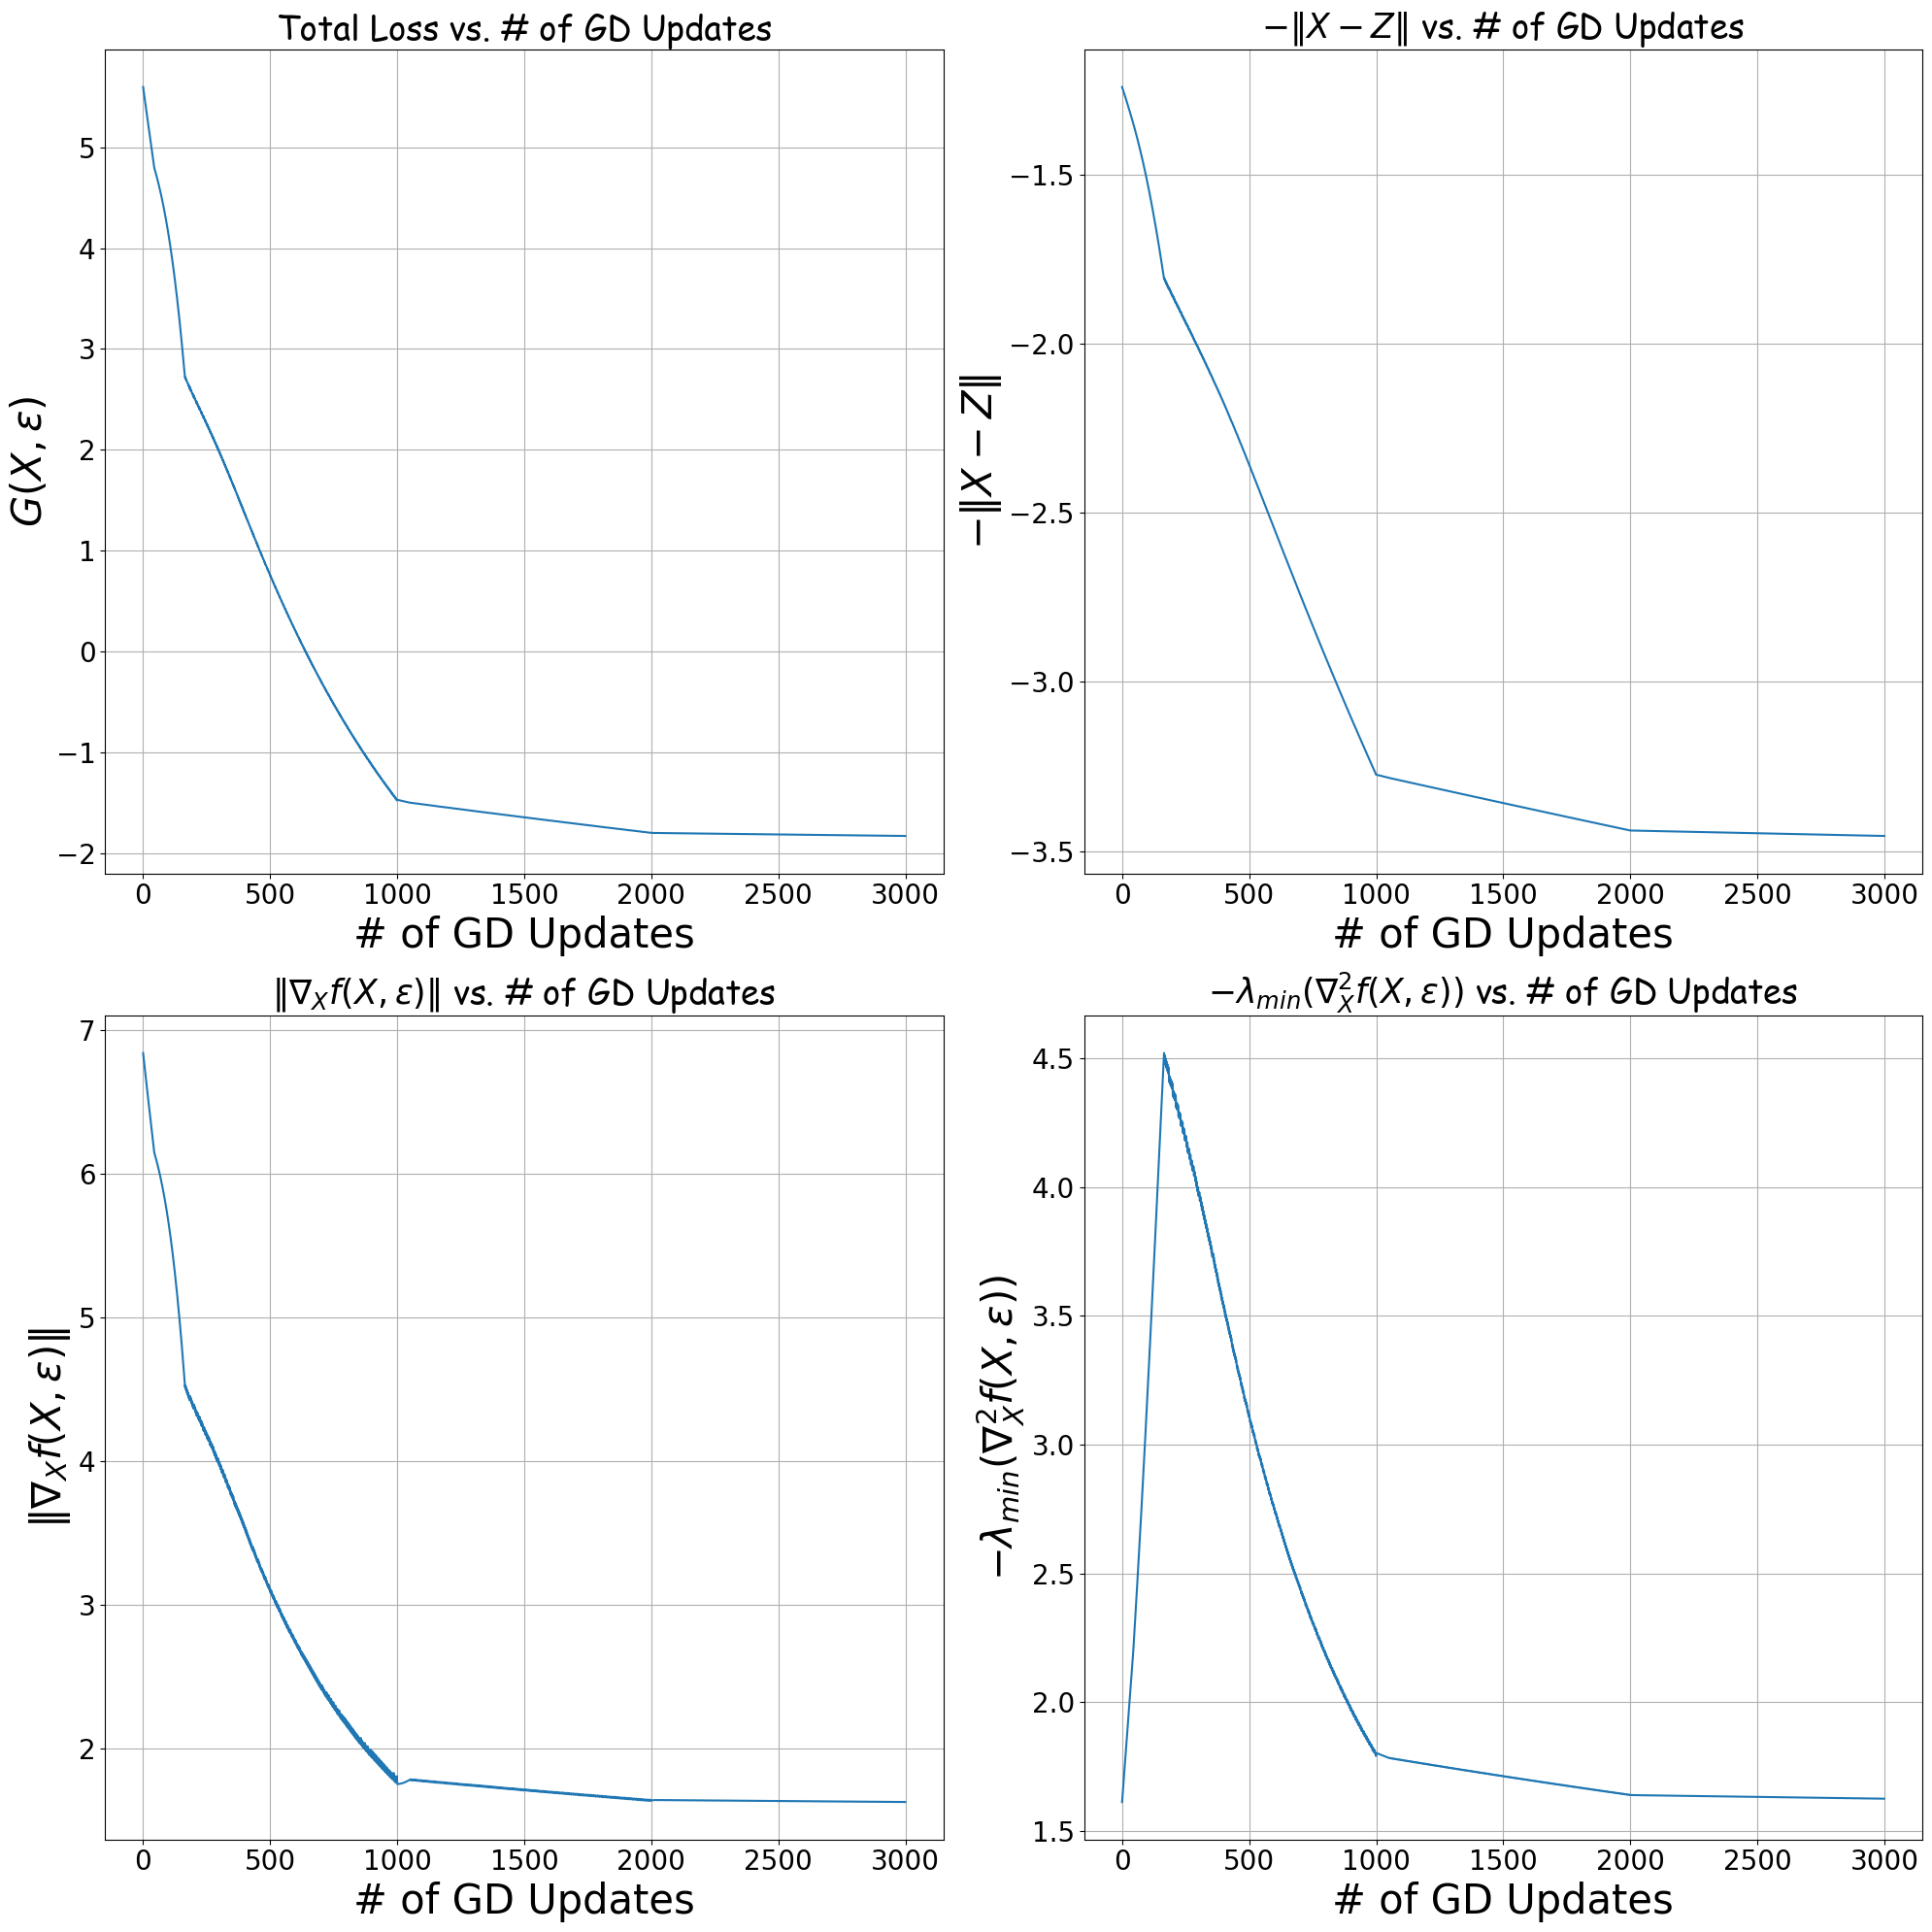

In [10]:
plot_loss(losses)

In [44]:
def loss_fn_diff(f, loss_type='A', coeff=0.1):
    def loss_A(X, Z, e):
        assert X.size() == Z.size()
        w, h = X.size()
        f_Z = f(Z, Z, e)
        f_X = f(X, Z, e)
        diff_loss = f_Z - f_X 
        first_order_loss_X = torch.linalg.matrix_norm(grad(f(X, Z, e), X, create_graph=True)[0])
        # first_order_loss_Z = torch.linalg.matrix_norm(grad(f(Z, Z, e), Z, create_graph=True)[0])
        second_order_loss_X = -torch.linalg.eigvalsh(hessian(f, (X, Z, e), create_graph=True)[0][0].reshape(w,h,-1).reshape(w*h,-1))[0]
        # second_order_loss_Z = -torch.linalg.eigvalsh(hessian(f, (Z, Z, e), create_graph=True)[1][1].reshape(w,h,-1).reshape(w*h,-1))[0]
        transform_loss = -torch.linalg.matrix_norm(X @ X.T - Z @ Z.T + e, ord='fro').square()
        return diff_loss + 0.5 * transform_loss + coeff * (first_order_loss_X + second_order_loss_X), diff_loss.item(), first_order_loss_X.item(), 0, second_order_loss_X.item(), 0, f_X.item(), f_Z.item(), transform_loss.item()
    def loss_B(X, Z, e):
        assert X.size() == Z.size()
        w, h = X.size()
        f_Z = f(Z, Z, e)
        f_X = f(X, Z, e)
        diff_loss = f_Z - f_X 
        first_order_loss_X = torch.linalg.matrix_norm(grad(f(X, Z, e), X, create_graph=True)[0])
        # first_order_loss_Z = torch.linalg.matrix_norm(grad(f(Z, Z, e), Z, create_graph=True)[0])
        second_order_loss_X = -torch.linalg.eigvalsh(hessian(f, (X, Z, e), create_graph=True)[0][0].reshape(w,h,-1).reshape(w*h,-1))[0]
        # second_order_loss_Z = -torch.linalg.eigvalsh(hessian(f, (Z, Z, e), create_graph=True)[1][1].reshape(w,h,-1).reshape(w*h,-1))[0]
        transform_loss = -torch.linalg.matrix_norm(X @ X.T - Z @ Z.T, ord='fro').square()
        return diff_loss + 0.2 * transform_loss + coeff * torch.maximum(first_order_loss_X, second_order_loss_X), diff_loss.item(), first_order_loss_X.item(), 0, second_order_loss_X.item(), 0, f_X.item(), f_Z.item(), transform_loss.item()
    
    if loss_type == 'A':
        return loss_A
    elif loss_type == 'B':
        return loss_B
    else:
        raise NotImplementedError

In [12]:
@torch.no_grad()
def project(X, Z, E, mask, coherence, max_norm):
    n, r = X.size()
    # incoherence projection of X
    # row_norm_X = torch.linalg.vector_norm(X, ord=2, dim=1)
    # frob_norm_X = torch.linalg.matrix_norm(X, ord='fro')
    # row_norm_X.div_(frob_norm_X * np.sqrt(coherence / n))
    # scale_X = torch.maximum(row_norm_X, torch.ones_like(row_norm_X))
    # X.div_(scale_X.unsqueeze(-1))
    # norm_X = torch.linalg.matrix_norm(X, ord='fro')
    # print(f"Before: {norm_X}")
    # if norm_X > 2:
    #    X.data = X.data / norm_X * 2
    # norm_X = torch.linalg.matrix_norm(X, ord='fro')
    # print(f"After: {norm_X}")
    # incoherence projection of Z
    row_norm_Z = torch.linalg.vector_norm(Z, ord=2, dim=1)
    frob_norm_Z = torch.linalg.matrix_norm(Z, ord='fro')
    row_norm_Z.div_(frob_norm_Z * np.sqrt(coherence / n)) 
    scale_Z = torch.maximum(row_norm_Z, torch.ones_like(row_norm_Z))
    Z.div_(scale_Z.unsqueeze(-1))
    # norm_Z = torch.linalg.matrix_norm(Z, ord='fro')
    # if norm_Z > 2:
    #    Z.data = Z.data / norm_Z * 2
    # norm projection
    norm_E = torch.linalg.matrix_norm(E * mask, ord='fro')
    if norm_E > max_norm:
        E.data = E.data / norm_E * max_norm


In [13]:
def clip_grad_norm(gradient, max_norm=1):
    norm_grad = torch.linalg.matrix_norm(gradient, ord='fro')
    return gradient * min(1, max_norm / norm_grad)

In [39]:
def compute_X_Z_e(coherence, error_norm, p, n, rank, device, coeff=(1,4), loss_type='A', optim='Adam',iters=100, lr=0.001):
    prob_mat = torch.zeros((n, n))
    prob_mat = prob_mat + p
    mask = torch.bernoulli(prob_mat).to(device)
    # m = int(torch.sum(mask == 1).item())
    def f(U, Z, e):
        return ((U @ U.T - Z @ Z.T + e) * mask).square().sum() / (4 * p)
    X = torch.rand((n, rank), requires_grad=True).to(device)
    Z = torch.rand((n, rank), requires_grad=True).to(device)
    E = torch.zeros((n, n), requires_grad=True).to(device)
    if optim == 'Adam':
        optimizer = Adam([X, Z, E], lr=lr)
    elif optim == 'SGD':
        optimizer = SGD([X, Z, E], lr=lr, momentum=0.9, weight_decay=1e-4)
    else:
        raise NotImplementedError
    losses = []
    # loss before training
    criterion = loss_fn_diff(f, loss_type, coeff[0])
    loss, diff, grad_X, grad_Z, hess_X, hess_Z, f_X, f_Z, trans = criterion(X, Z, E)
    losses.append((loss.item(), diff, grad_X, grad_Z, hess_X, hess_Z, f_X, f_Z, trans))
    for i in tqdm(range(iters), leave=False):
        # Define Criterion
        alpha = coeff[0] + i * (coeff[1] - coeff[0]) / iters
        criterion = loss_fn_diff(f, loss_type, alpha)
        # Training
        optimizer.zero_grad()
        loss, diff, grad_X, grad_Z, hess_X, hess_Z, f_X, f_Z, trans = criterion(X, Z, E)
        loss.backward()
        torch.nn.utils.clip_grad_norm_([X, Z, E], max_norm=1.0, norm_type=2)
        optimizer.step()
        # Adjust learning rate
        new_lr = 0.5 * (lr + 2e-5) + 0.5 * (lr - 2e-5) * np.cos(np.pi * i / iters)
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
        # Project to feasible set
        project(X, Z, E, mask, coherence, error_norm)
        # Evaluating
        losses.append((loss.item(), diff, grad_X, grad_Z, hess_X, hess_Z, f_X, f_Z, trans))
        # Early Stop
        if abs(diff) < 1e-6 or abs(grad_X) > 1e2 or abs(hess_X) > 1e2 or abs(trans) > 1e2:
            break
        
    return X, E, Z, mask, losses
    

In [25]:
def plot_loss_2(losses):
    fig, ax = plt.subplots(3, 2, figsize=(20, 30), tight_layout=True)
    loss = [loss[0] for loss in losses]
    diff = [loss[1] for loss in losses]
    grad_X = [loss[2] for loss in losses]
    grad_Z = [loss[3] for loss in losses]
    hess_X = [loss[4] for loss in losses]
    hess_Z = [loss[5] for loss in losses]
    trans = [loss[8] for loss in losses]
    
    ax[0][0].plot(loss)
    ax[0][1].plot(diff)
    ax[1][0].plot(grad_X)
    ax[1][1].plot(trans)
    ax[2][0].plot(hess_X)
    ax[2][1].plot(hess_Z)

    ax[0][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][0].set_ylabel(r"$g(X,Z,E)$", fontsize=30)
    ax[0][0].set_title(f"Total Loss vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][0].xaxis.set_tick_params(labelsize=20)
    ax[0][0].yaxis.set_tick_params(labelsize=20)
    ax[0][0].grid()

    ax[0][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][1].set_ylabel(r"$f(Z)-f(X)$", fontsize=30)
    ax[0][1].set_title(r"$f(Z)-f(X)$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][1].xaxis.set_tick_params(labelsize=20)
    ax[0][1].yaxis.set_tick_params(labelsize=20)
    ax[0][1].grid()

    ax[1][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][0].set_ylabel(r"$\|\nabla_Xf(X)\|_F$", fontsize=30)
    ax[1][0].set_title(r"$\|\nabla_Xf(X)\|_F$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][0].xaxis.set_tick_params(labelsize=20)
    ax[1][0].yaxis.set_tick_params(labelsize=20)
    ax[1][0].set_yscale('log')
    ax[1][0].grid()

    ax[1][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][1].set_ylabel(r"$-\|XX^T-ZZ^T\|_F^2$", fontsize=30)
    ax[1][1].set_title(r"$-\|XX^T-ZZ^T\|_F^2$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][1].xaxis.set_tick_params(labelsize=20)
    ax[1][1].yaxis.set_tick_params(labelsize=20)
    ax[1][1].grid()

    ax[2][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[2][0].set_ylabel(r"$-\lambda_{min}(\nabla^2_Xf(X))$", fontsize=30)
    ax[2][0].set_title(r"$-\lambda_{min}(\nabla^2_Xf(X))$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[2][0].xaxis.set_tick_params(labelsize=20)
    ax[2][0].yaxis.set_tick_params(labelsize=20)
    # ax[2][0].set_yscale('log')
    ax[2][0].grid()

    ax[2][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[2][1].set_ylabel(r"$-\lambda_{min}(\nabla^2_Zf(Z))$", fontsize=30)
    ax[2][1].set_title(r"$-\lambda_{min}(\nabla^2_Zf(Z))$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[2][1].xaxis.set_tick_params(labelsize=20)
    ax[2][1].yaxis.set_tick_params(labelsize=20)
    # ax[2][1].set_yscale('log')
    ax[2][1].grid()

In [40]:
def DSE(coherence, error_norm, p, n, rank, device, coeff=(1,4), loss_type='A', optim='Adam', iters=100, lr=0.001, search_loops=10):
    same_seed(0)
    for i in range(search_loops):
        X, E, Z, mask, losses = compute_X_Z_e(coherence, error_norm, p, n, rank, device, coeff, loss_type, optim, iters, lr)
        if len(losses) == iters + 1:
            print(f"======= Search Iter {i} =======")
            print(mask.data)
            print(f"(TT_loss, diff, grad_X, hess_X, trans) = ({losses[-1][0]:.2e},{losses[-1][1]:.2e},{losses[-1][2]:.2e},{losses[-1][4]:.2e},{losses[-1][8]:.2e})")
            print(f"X = {X.data}")
            print(f"Z = {Z.data}")
            print("==========================")

  0%|          | 0/5000 [00:00<?, ?it/s]

  3%|▎         | 157/5000 [00:00<00:21, 225.92it/s]


tensor([[1., 0., 1., 1., 1.],
        [0., 1., 0., 1., 0.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 1., 0., 1.]])
tensor([[0.34],
        [0.37],
        [0.12],
        [0.20],
        [0.20]])
tensor([[0.34],
        [0.37],
        [0.12],
        [0.20],
        [0.19]])
tensor([[-5.29e-06,  0.00e+00, -4.46e-07, -1.21e-06,  3.84e-06],
        [ 0.00e+00,  1.21e-07,  0.00e+00,  5.24e-07,  0.00e+00],
        [-4.46e-07,  5.74e-07,  3.06e-07,  3.76e-07,  2.20e-06],
        [ 0.00e+00,  0.00e+00,  0.00e+00,  3.22e-07,  3.45e-06],
        [ 0.00e+00,  0.00e+00,  2.20e-06,  0.00e+00,  5.73e-06]])
tensor([[0.12, 0.13, 0.04, 0.07, 0.07],
        [0.13, 0.14, 0.04, 0.07, 0.07],
        [0.04, 0.04, 0.01, 0.02, 0.02],
        [0.07, 0.07, 0.02, 0.04, 0.04],
        [0.07, 0.07, 0.02, 0.04, 0.04]])
tensor([[0.12, 0.13, 0.04, 0.07, 0.07],
        [0.13, 0.14, 0.04, 0.07, 0.07],
        [0.04, 0.04, 0.01, 0.02, 0.02],
        [0.07, 0.07, 0.02, 0.04, 0.04],


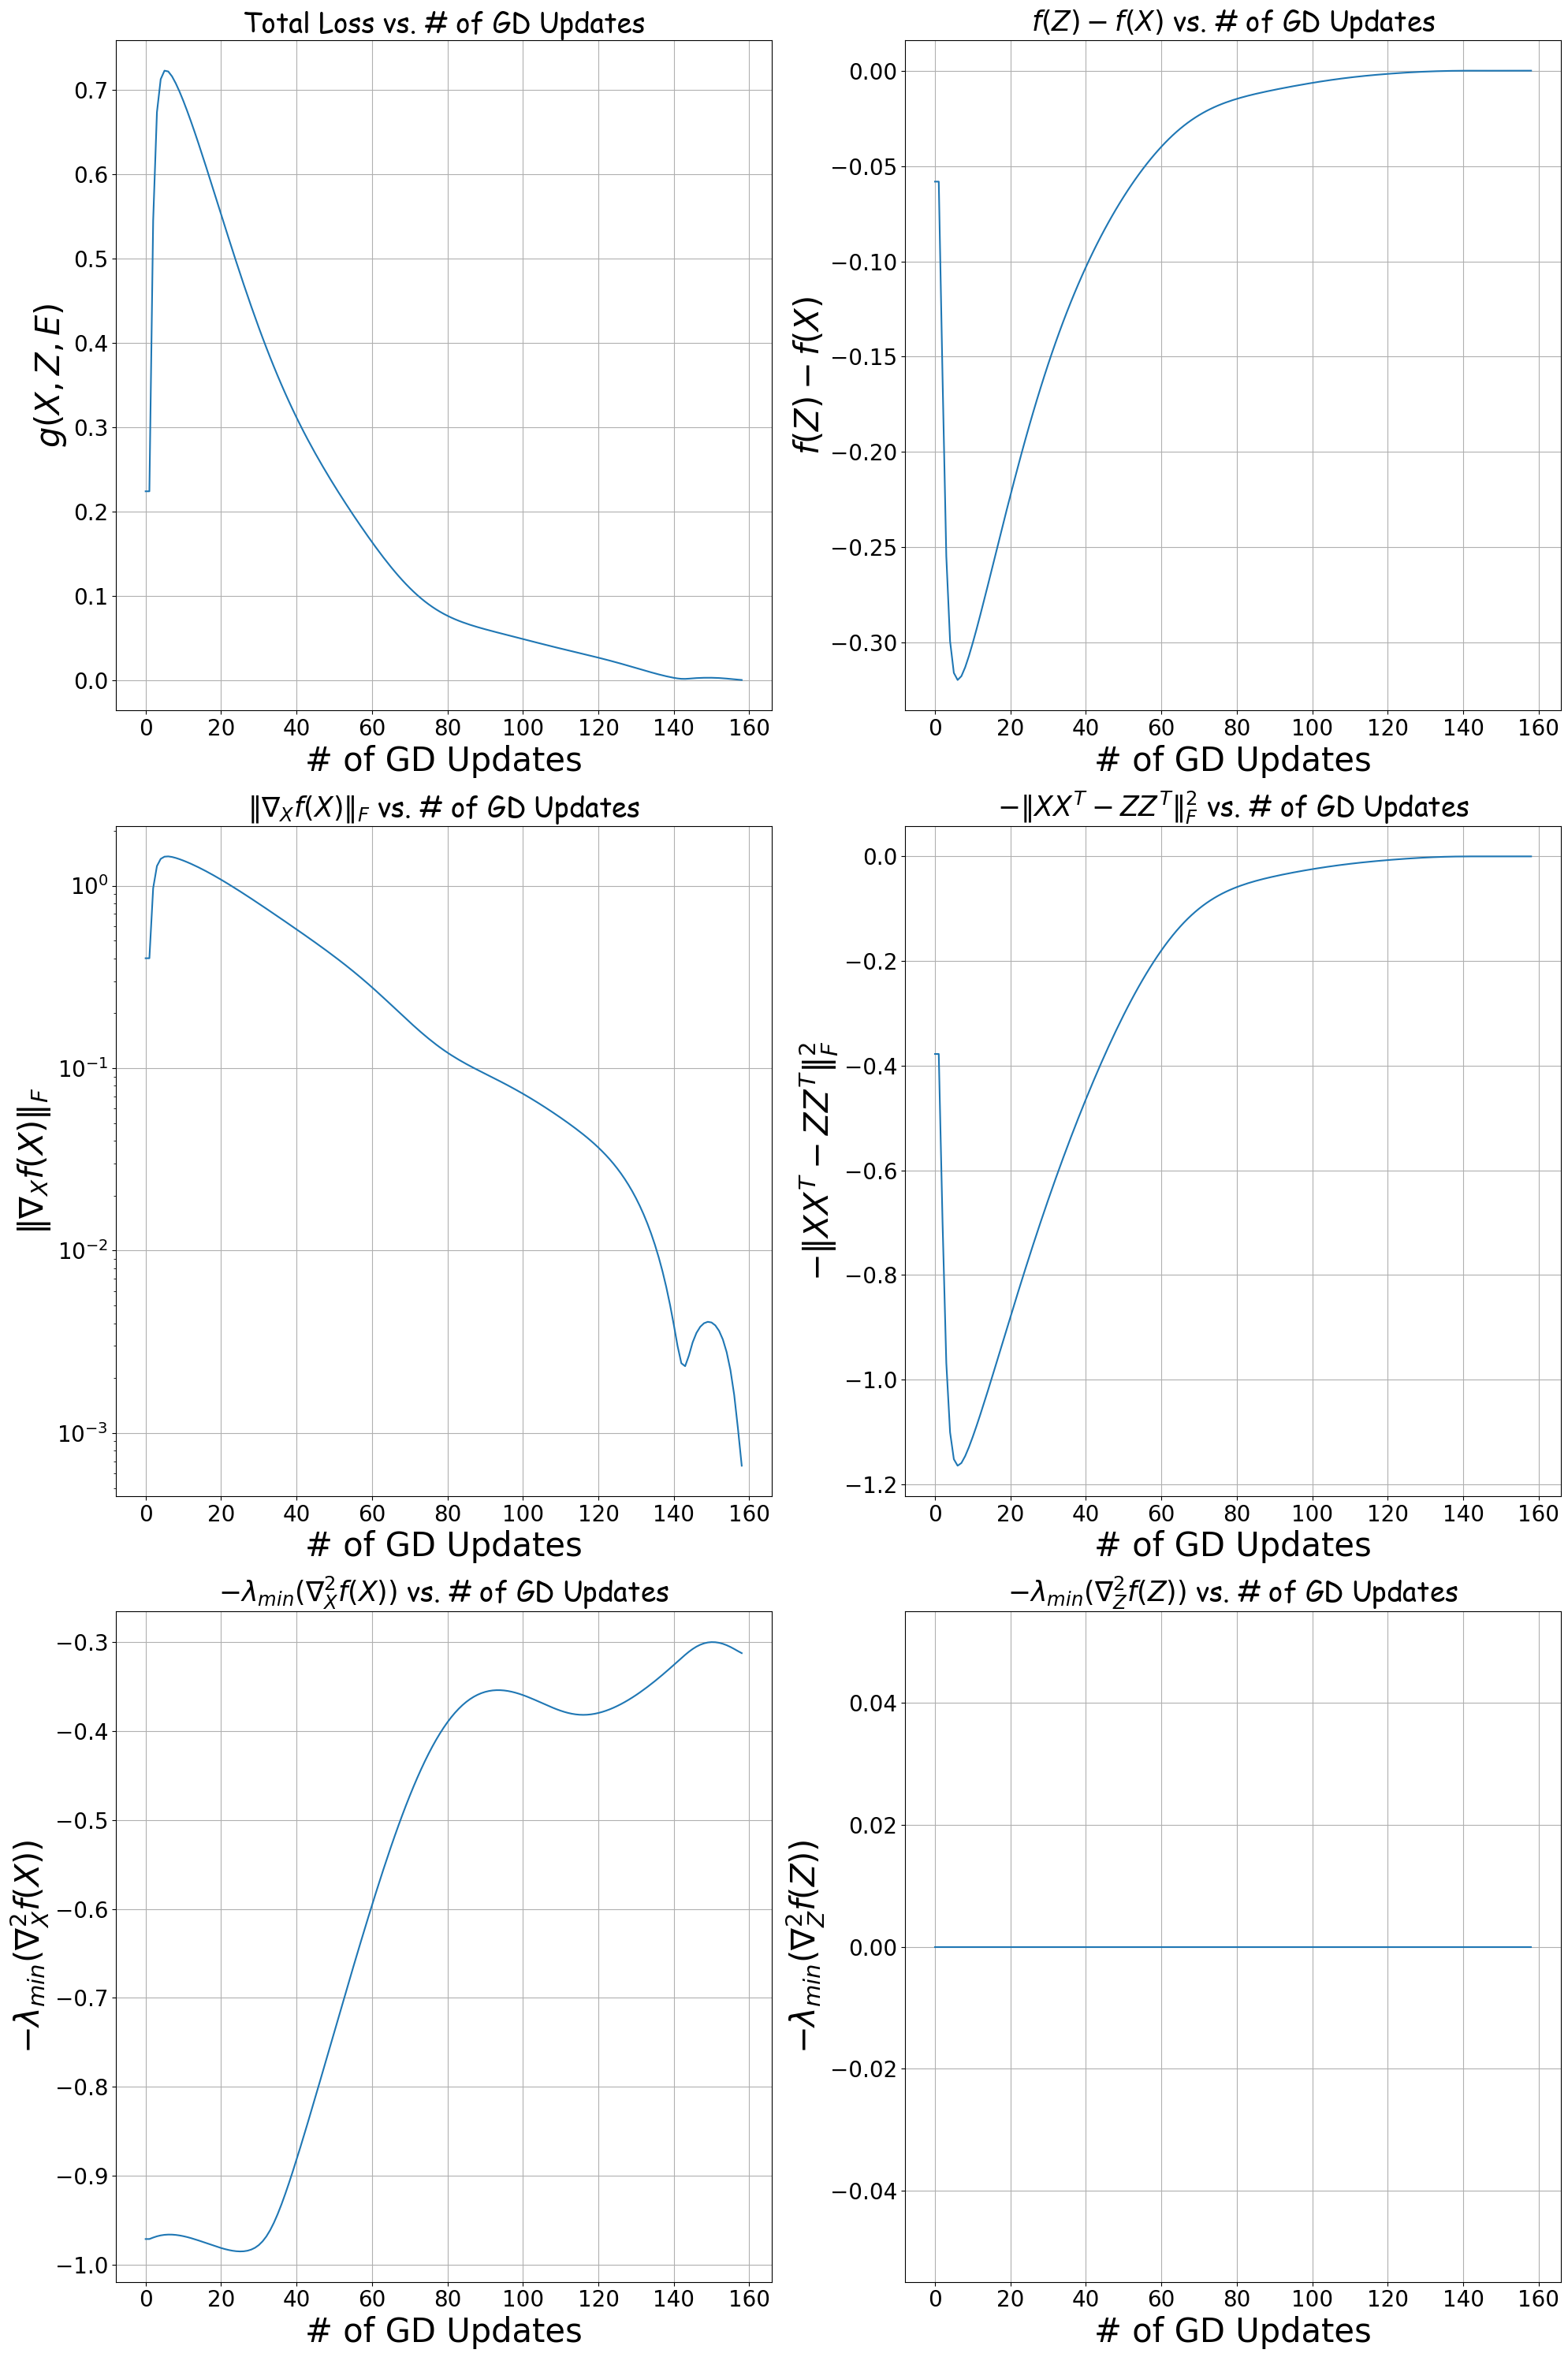

In [30]:
coherence   = 2   # [1, n/r]
max_norm    = 1e-5
p           = 0.5
n           = 5
rank        = 1
iters       = 5000
lr          = 0.001
coeff       = (0.8,0.8)
loss_type   = 'B'
optim       = 'SGD'
device      = 'cuda:0' if torch.cuda.is_available() else 'cpu'

same_seed(0)
X, E, Z, mask, losses = compute_X_Z_e(coherence, max_norm, p, n, rank, device, coeff, loss_type, optim, iters, lr)

# print(f"m = {m}")
print(mask.data)
print(X.data)
print(Z.data)
print(E.data)
print((X @ X.T).data)
print((Z @ Z.T).data)
print(torch.linalg.matrix_norm(X - Z, ord='fro'))
print(torch.linalg.matrix_norm((X @ X.T) - (Z @ Z.T) + E, ord='fro'))
print(torch.linalg.matrix_norm((X @ X.T), ord='fro'))
print(torch.linalg.matrix_norm((Z @ Z.T), ord='fro'))
print(losses[0][1], losses[-1][1])

print(losses[0][4], losses[-1][4])
# print(losses[0][6], losses[-1][6])
# print(losses[0][7], losses[-1][7])
print(losses[0][8], losses[-1][8])
plot_loss_2(losses)

In [45]:
coherence   = 2   # [1, n/r]
max_norm    = 1e-9
p           = 0.8
n           = 5
rank        = 1
iters       = 3000
lr          = 0.001
coeff       = (4,4)
loss_type   = 'B'
optim       = 'SGD'
device      = 'cuda:0' if torch.cuda.is_available() else 'cpu'
sear_loops  = 20

DSE(coherence, max_norm, p, n, rank, device, coeff, loss_type, optim, iters, lr, sear_loops)

  0%|          | 0/3000 [00:00<?, ?it/s]

======= Search Iter 2 =======
tensor([[1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1.],
        [1., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1.]])
(TT_loss, diff, grad_X, hess_X, trans) = (3.00e-04,-3.16e-06,8.10e-05,8.08e-05,-1.05e-04)
X = tensor([[0.02],
        [0.05],
        [0.12],
        [0.01],
        [0.02]])
Z = tensor([[0.03],
        [0.07],
        [0.07],
        [0.02],
        [0.02]])


======= Search Iter 11 =======
tensor([[0., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1.],
        [1., 0., 0., 1., 1.]])
(TT_loss, diff, grad_X, hess_X, trans) = (-1.35e-02,-3.44e-03,4.83e-06,-4.62e-06,-5.05e-02)
X = tensor([[-0.01],
        [ 0.08],
        [ 0.27],
        [ 0.01],
        [-0.23]])
Z = tensor([[0.02],
        [0.22],
        [0.26],
        [0.07],
        [0.26]])
